In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '1' # imposes only one core
import numpy as np
import matplotlib.pyplot as plt
import h5py
import skopt
from skopt.space import Real
from skopt.learning import GaussianProcessRegressor as GPR
from skopt.learning.gaussian_process.kernels import Matern, WhiteKernel, Product, ConstantKernel
import matplotlib as mpl
#Latex
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')
# In val_functions there are the validation strategies
%run ./Val_Functions.ipynb
# In functions there are the ESN functions
%run ./Functions.ipynb

### Dataset generation

We start by generating the timeseries of the Lorenz system using forward Euler nad splitting the data in washout, training, validation and test.

In [2]:
## starting point on the attractor
u0 = np.array([7.432487609628195, 10.02071718705213, 29.62297428638419])

dt        = 0.01            # time step
t_lyap    = 0.9**(-1)       # Lyapunov Time
N_lyap    = int(t_lyap/dt)  # number of time steps in one Lyapunov time

# number of time steps for washout, train, validation, test
N_washout = 1*N_lyap
N_train   = 8*N_lyap
N_val     = 3*N_lyap
N_test    = 500*N_lyap
    
# generate data 
U    = solve_ode(N_washout+N_train+N_val+N_test, dt, u0)

# compute norm
# U_data = U[:N_washout+N_train+N_val]
# m = U_data.min(axis=0)
# M = U_data.max(axis=0)
# norm = M-m

norm      = np.array([35.23020746, 45.09776766, 36.07598481])

# washout
U_washout = U[:N_washout]
# training
U_t   = U[N_washout:N_washout+N_train-1]
Y_t   = U[N_washout+1:N_washout+N_train]
# training + validation
U_tv  = U[N_washout:N_washout+N_train+N_val-1]
Y_tv  = U[N_washout+1:N_washout+N_train+N_val]
# validation
Y_v  = U[N_washout+N_train:N_washout+N_train+N_val] 

### ESN Initiliazation Hyperparameters

To generate the Echo State Networks realizations we set the hyperparameters (even the ones that are optimized during validation)

In [3]:
bias_in = 1.0 #input bias
bias_out = 1.0 #output bias 
N_units = 100 #units in the reservoir
dim = 3 # dimension of inputs (and outputs) 
connectivity   = 3 

sigma_in = 1.0 #input scaling
rho = 1.0  # spectral radius
sparseness =  1 - connectivity/(N_units-1) 

tikh = 1e-11  # Tikhonov factor

###  Grid Search and Bayesian Optimization

Here we set the parameters for Grid Search and Bayesian Optimization.

In [4]:
n_tot = 49    #Total Number of Function Evaluatuions
n_in  = 0     #Number of Initial random points

spec_in     = 0.1   #range for hyperparameters (spectral radius and input scaling)
spec_end    = 1.
in_scal_in  = 0.5
in_scal_end = 5.

# In case we want to start from a grid_search, the first n_grid^2 points are from grid search
# if n_grid^2 = n_tot then it is pure grid search
n_grid = 7  # (with n_grid**2 < n_tot you get Bayesian Optimization)

# computing the points in the grid
if n_grid > 0:
    x1    = [[None] * 2 for i in range(n_grid**2)]
    k     = 0
    for i in range(n_grid):
        for j in range(n_grid):
            x1[k] = [spec_in + (spec_end - spec_in)/(n_grid-1)*i,
                     in_scal_in + (in_scal_end - in_scal_in)/(n_grid-1)*j]
            k   += 1

# range for hyperparameters
search_space = [Real(spec_in, spec_end, name='spectral_radius'),
                Real(in_scal_in, in_scal_end, name='input_scaling')]

# ARD 5/2 Matern Kernel with sigma_f in front for the Gaussian Process
kernell = ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-2, 1e2))*\
                  Matern(length_scale=[0.1,0.1], nu=2.5, length_scale_bounds=(1e-2, 1e1)) 


#Hyperparameter Optimization using either Grid Search or Bayesian Optimization
def g(val):
    
    #Gaussian Process reconstruction
    b_e = GPR(kernel = kernell,
            normalize_y = True, #if true mean assumed to be equal to the average of the obj function data, otherwise =0
            n_restarts_optimizer = 2,  #number of random starts to find the gaussian process hyperparameters
            noise = 1e-10, # only for numerical stability
            random_state = 10) # seed
    
    
    #Bayesian Optimization
    res = skopt.gp_minimize(val,                         # the function to minimize
                      search_space,                      # the bounds on each dimension of x
                      base_estimator       = b_e,        # GP kernel
                      acq_func             = "gp_hedge", # the acquisition function
                      n_calls              = n_tot,      # total number of evaluations of f
                      x0                   = x1,         # Initial grid search points to be evaluated at
                      n_random_starts      = n_in,       # the number of additional random initialization points
                      n_restarts_optimizer = 3,          # number of tries for each acquisition
                      random_state         = 10,         # seed
                           )   
    return res

### Validate Echo State
Select validation function and model-free or model-informed architecture to select the hyperparameters for each realization in the ensemble of networks

Realization    : 1
Best Results: x [0.7  1.25] f 5.46643858306828


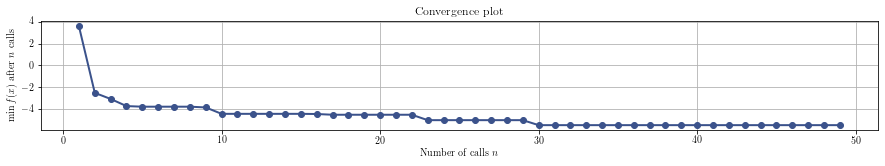

Realization    : 2
Best Results: x [0.4 2. ] f 4.692355481058219


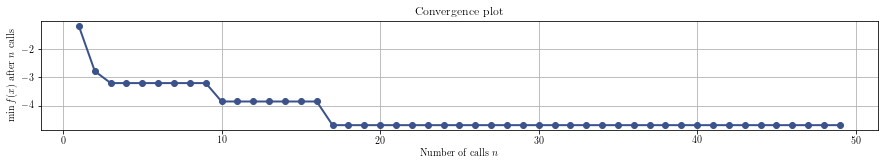

Realization    : 3
Best Results: x [0.55 1.25] f 5.216016504135376


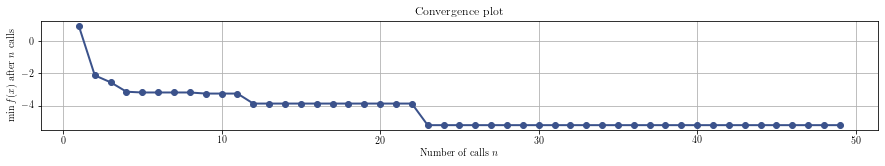

Realization    : 4
Best Results: x [0.55 2.  ] f 5.0712067318612934


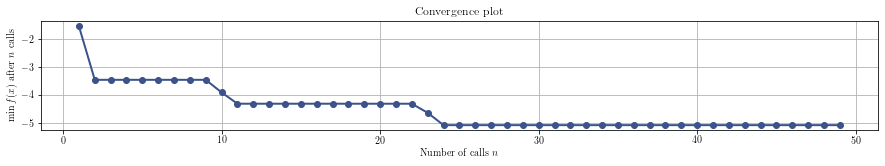

Realization    : 5
Best Results: x [0.7  1.25] f 4.815258209142892


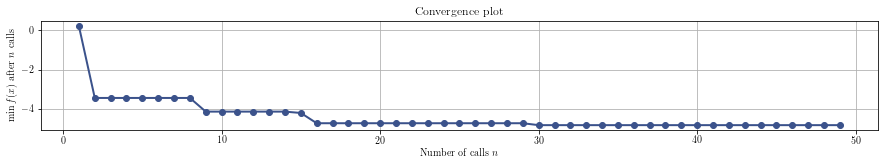

Realization    : 6
Best Results: x [1.   1.25] f 5.4104032658132555


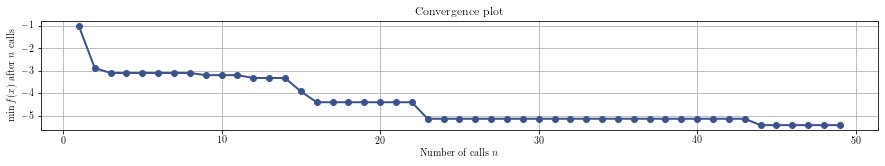

Realization    : 7
Best Results: x [0.55 2.  ] f 4.926507434135432


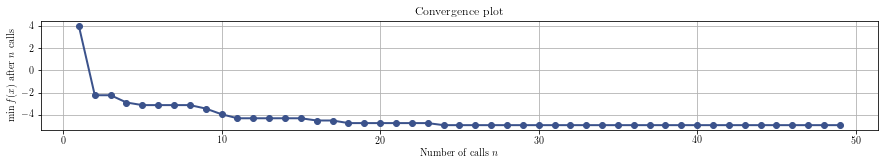

Realization    : 8
Best Results: x [1.   1.25] f 5.391325279040693


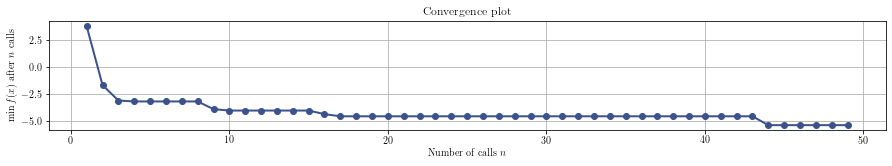

Realization    : 9
Best Results: x [0.7  1.25] f 4.972063131407308


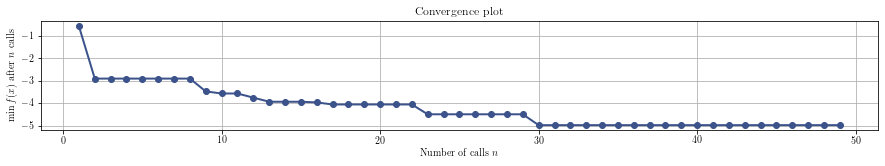

Realization    : 10
Best Results: x [0.55 2.  ] f 5.437779057866088


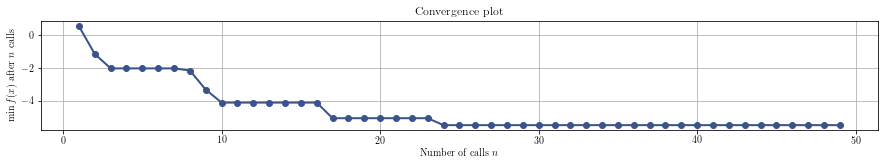

Realization    : 11
Best Results: x [1.   1.25] f 4.722733099557902


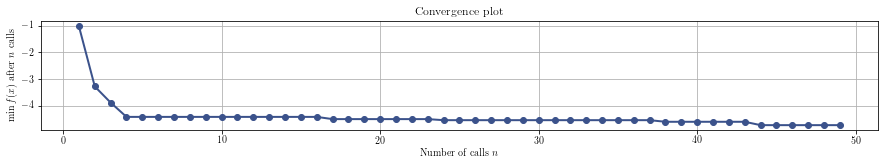

Realization    : 12
Best Results: x [0.7 2. ] f 5.422793056943093


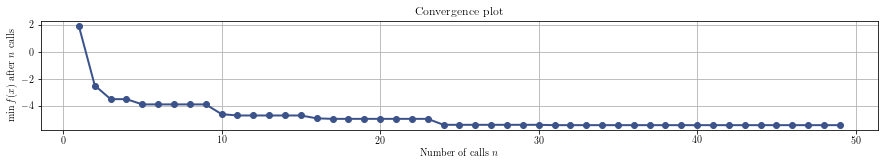

Realization    : 13
Best Results: x [0.4 2. ] f 5.6817918573167026


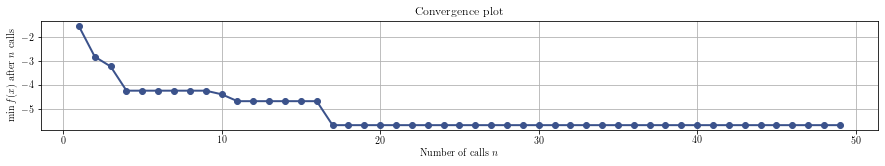

Realization    : 14
Best Results: x [0.55 1.25] f 4.636859045017214


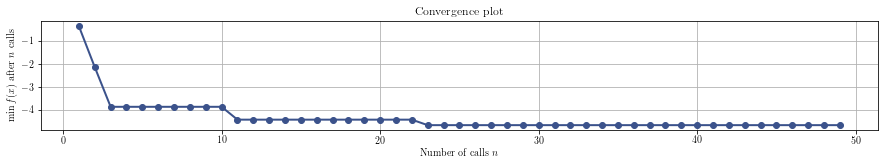

Realization    : 15
Best Results: x [1.  0.5] f 4.933848611430735


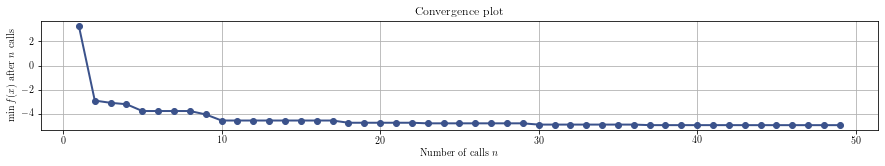

Realization    : 16
Best Results: x [0.55 1.25] f 5.103278408762127


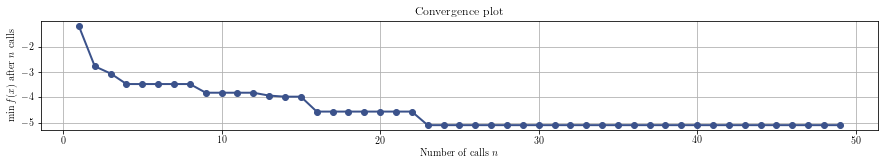

Realization    : 17
Best Results: x [0.7  1.25] f 5.005718092272762


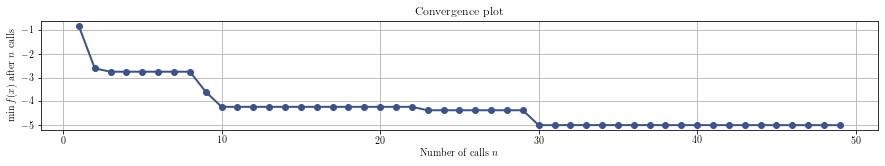

Realization    : 18
Best Results: x [0.25 3.5 ] f 4.619815206563207


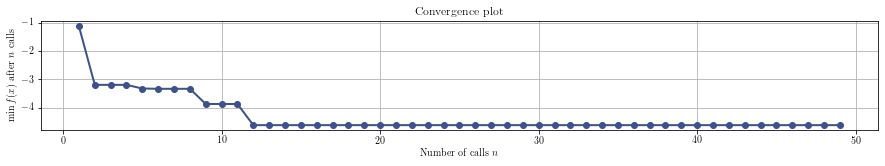

Realization    : 19
Best Results: x [0.55 2.  ] f 4.569941117114


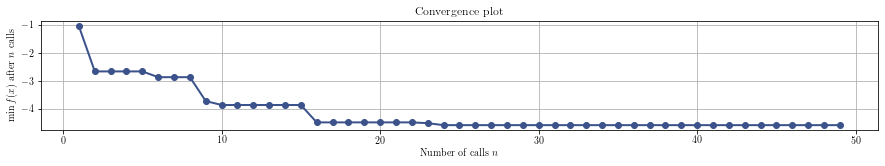

Realization    : 20
Best Results: x [0.55 2.  ] f 5.422215310265102


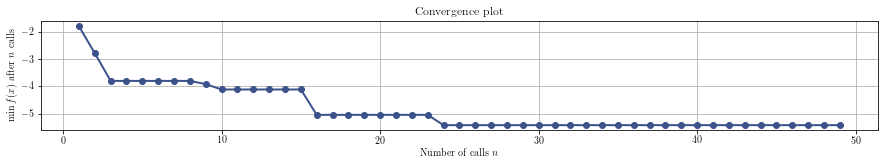

Realization    : 21
Best Results: x [0.25 2.75] f 4.688343847283901


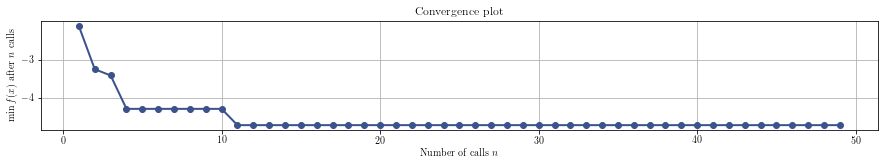

Realization    : 22
Best Results: x [0.55 2.  ] f 5.283425587737408


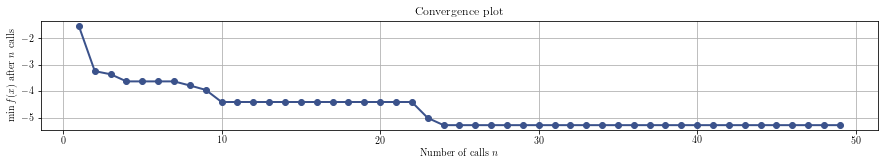

Realization    : 23
Best Results: x [0.7  1.25] f 4.930705224583787


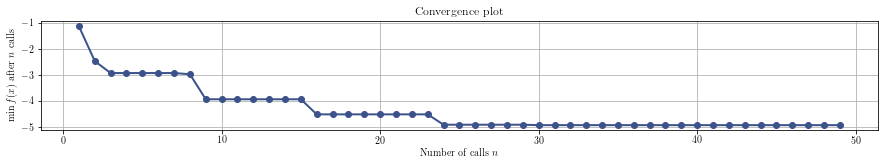

Realization    : 24
Best Results: x [0.85 2.75] f 5.44235186118131


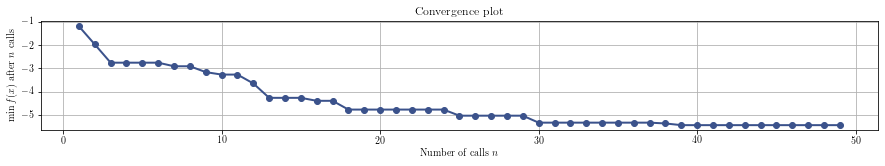

Realization    : 25
Best Results: x [0.85 1.25] f 4.905047366840345


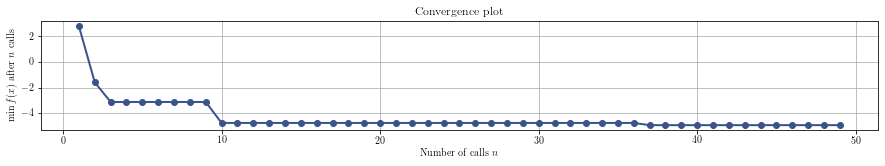

Realization    : 26
Best Results: x [0.85 1.25] f 4.597830301659226


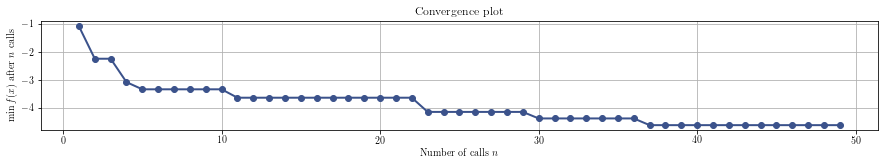

Realization    : 27
Best Results: x [1. 2.] f 5.2875785522579575


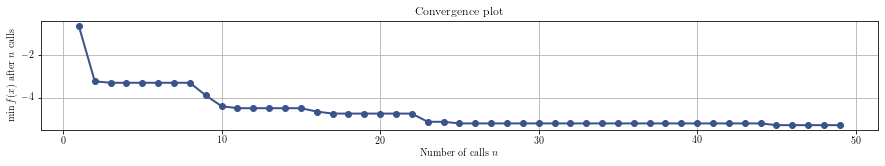

Realization    : 28
Best Results: x [0.55 2.  ] f 5.123958602202512


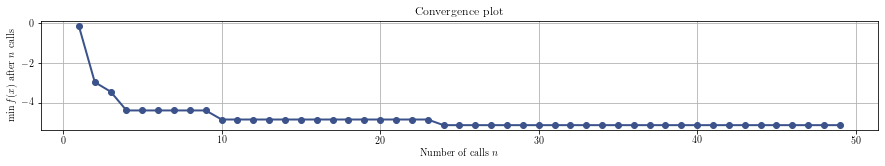

Realization    : 29
Best Results: x [0.7  1.25] f 4.991604210797906


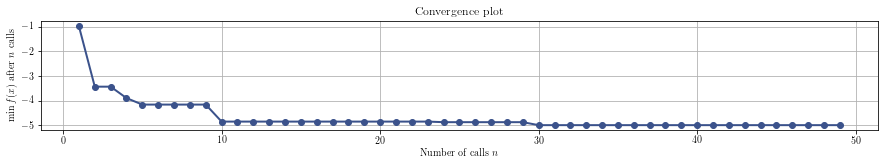

Realization    : 30
Best Results: x [0.85 1.25] f 4.798073235636419


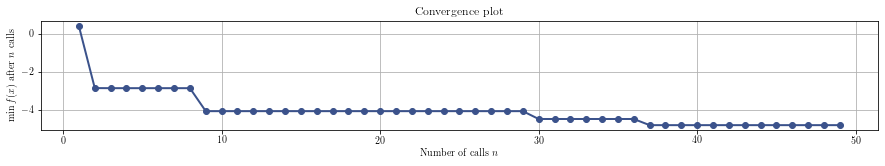

Realization    : 31
Best Results: x [0.55 2.  ] f 5.516367389594013


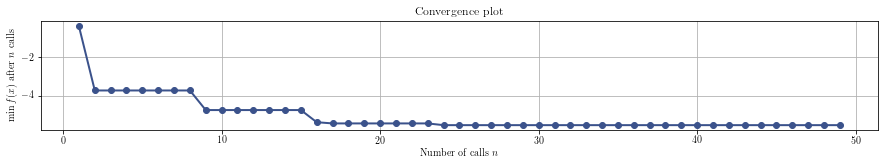

Realization    : 32
Best Results: x [0.85 1.25] f 4.711333608850141


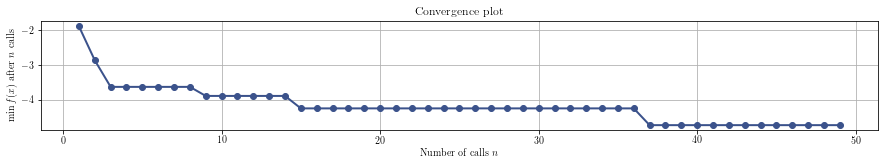

Realization    : 33
Best Results: x [0.7  1.25] f 5.142804676201586


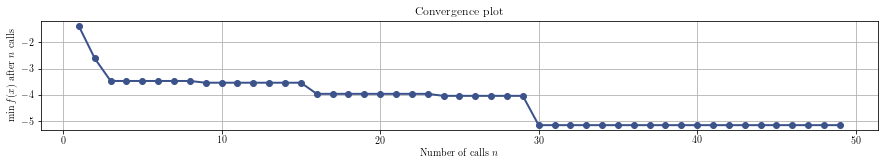

Realization    : 34
Best Results: x [1. 2.] f 4.961762046296554


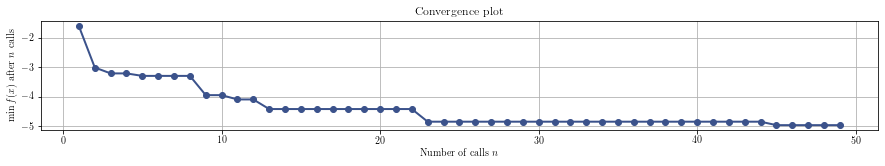

Realization    : 35
Best Results: x [0.7  1.25] f 5.956702403034523


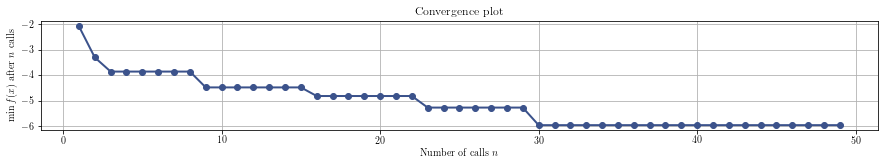

Realization    : 36
Best Results: x [0.55 2.  ] f 4.800101311411107


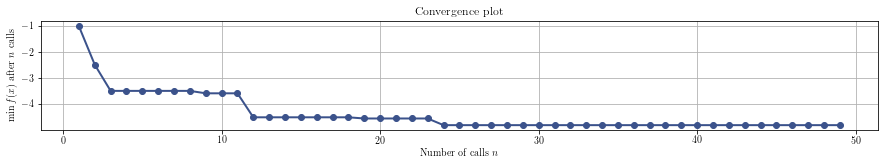

Realization    : 37
Best Results: x [0.4  1.25] f 4.506864595181054


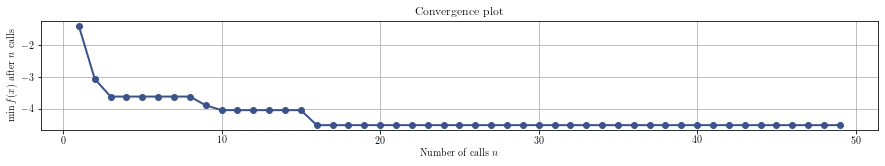

Realization    : 38
Best Results: x [0.85 1.25] f 5.295932410965864


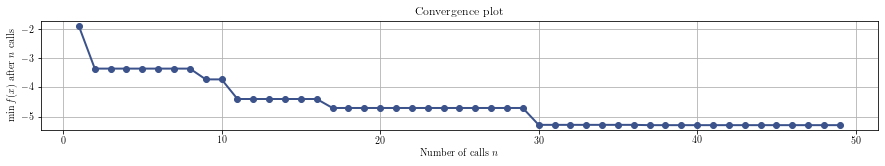

Realization    : 39
Best Results: x [0.55 2.  ] f 4.8206483807475164


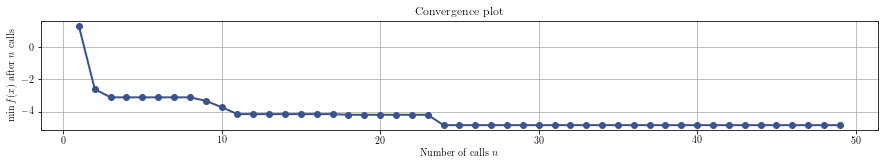

Realization    : 40
Best Results: x [0.4  1.25] f 4.652876428278181


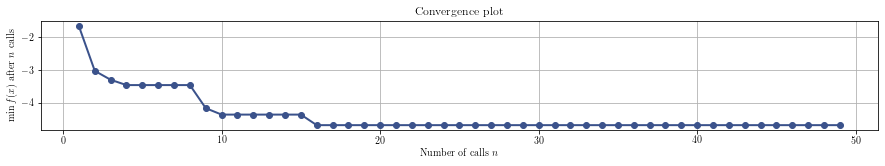

Realization    : 41
Best Results: x [1.   1.25] f 4.875310549097295


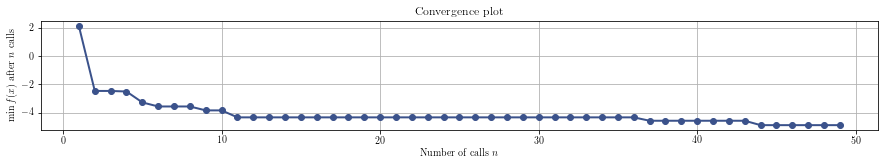

Realization    : 42
Best Results: x [0.55 2.75] f 5.158196488517077


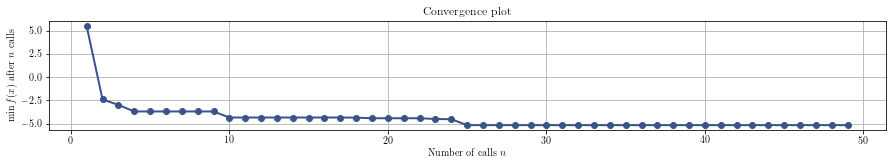

Realization    : 43
Best Results: x [0.4  1.25] f 4.777023445567606


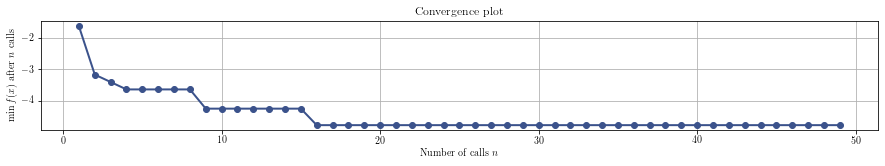

Realization    : 44
Best Results: x [0.4 2. ] f 5.202732314054481


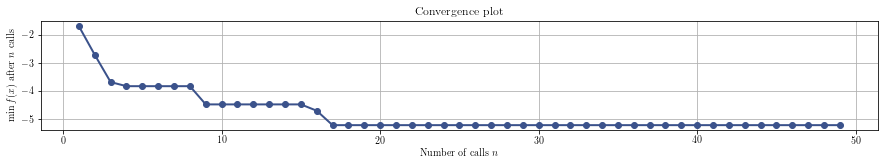

Realization    : 45
Best Results: x [0.7 2. ] f 5.424289656734281


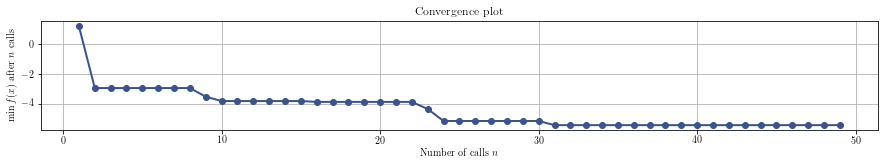

Realization    : 46
Best Results: x [0.7 0.5] f 5.078621114233783


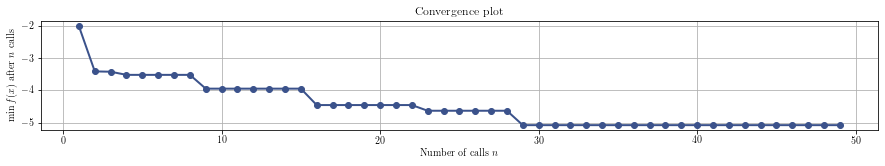

Realization    : 47
Best Results: x [0.7  1.25] f 5.199844089781673


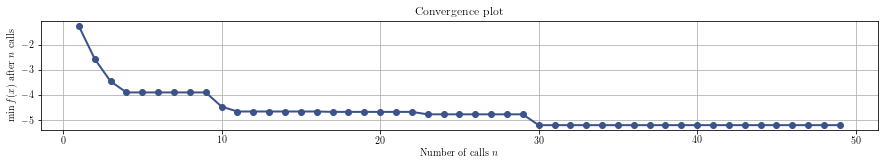

Realization    : 48
Best Results: x [0.4  1.25] f 4.990835716429633


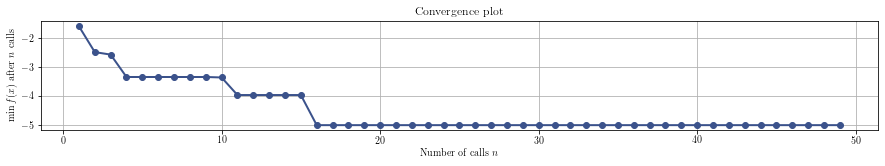

Realization    : 49
Best Results: x [0.85 1.25] f 4.995101861757469


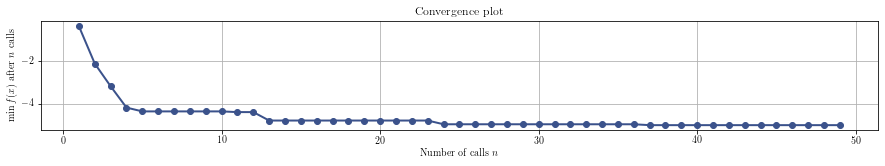

Realization    : 50
Best Results: x [0.7 2. ] f 5.477865021939467


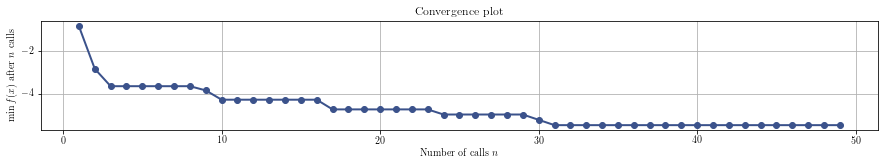

CPU times: user 3min 34s, sys: 643 ms, total: 3min 35s
Wall time: 3min 35s


In [5]:
%%time

from skopt.plots import plot_convergence

#Number of Networks in the ensemble
ensemble = 50
# Which validation strategy (implemented in Val_Functions.ipynb)
val      = RVC
# Computes the reduced order model and uses the model-informed architecture
model_informed = False
if model_informed:
    %run ./Functions_MI.ipynb
# to save the Gaussian Process reconstruction of the MSE in hyperparameter space
save_GP_reconstruction = False

    
#Quantities to be saved
par      = np.zeros((ensemble, 4))      # GP parameters
x_iters  = np.zeros((ensemble,n_tot,2)) # coordinates in hp space where f has been evaluated
f_iters  = np.zeros((ensemble,n_tot))   # values of f at those coordinates
minimum  = np.zeros((ensemble, 3))      # minima found per each member of the ensemble

# save the final gp reconstruction for each network
gps      = [None]*ensemble

for i in range(ensemble):
    
    print('Realization    :',i+1)
    
    # Win and W generation
    seed= i+1
    rnd = np.random.RandomState(seed)

    Win = np.zeros((dim+1, N_units))
    for j in range(N_units):
        Win[rnd.randint(0, dim+1),j] = rnd.uniform(-1, 1) #only one element different from zero per row
    
    # practical way to set the sparseness
    W = rnd.uniform(-1, 1, (N_units, N_units)) * (rnd.rand(N_units, N_units) < (1-sparseness))
    spectral_radius = np.max(np.abs(np.linalg.eigvals(W)))
    W /= spectral_radius #scaled to have unitary spec radius
    
    # Bayesian Optimization
    res        = g(val)
    
    #Saving Quantities for post_processing
    gps[i]     = res.models[-1]    
    gp         = gps[i]
    x_iters[i] = np.array(res.x_iters)
    f_iters[i] = np.array(res.func_vals)
    minimum[i] = np.append(res.x,res.fun)
    params     = gp.kernel_.get_params()
    key        = sorted(params)
    par[i]     = np.array([params[key[2]],params[key[5]][0], params[key[5]][1], gp.noise_])
    
    #Plotting Optimization Convergence for each network
    print('Best Results: x', minimum[i,:2], 'f', -minimum[i,2])
    plt.rcParams["figure.figsize"] = (15,2)
    plt.figure()
    plot_convergence(res)
    plt.show()

## Plot Results

Plots for the optimal hyperparameters found above.

Then the Gaussian Process reconstruction of the error in hyperparameter space.

25%, 50%, 75%: -4.803890535844054 -5.000409977015115 -5.293843946288887


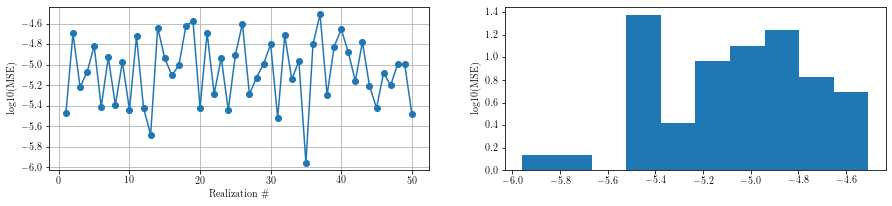

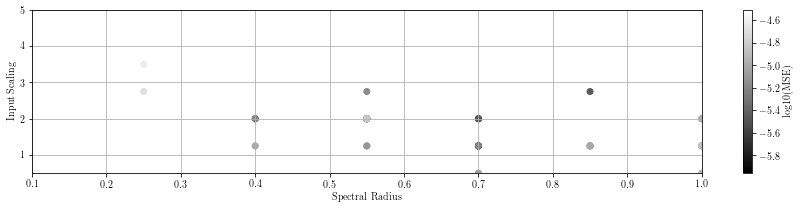

In [6]:
# VAlidation MSE percentiles
print('25%, 50%, 75%:',
      -np.quantile(-minimum[:,2],0.25),-np.median(-minimum[:,2]),-np.quantile(-minimum[:,2],0.75))

#Performance of the different networks
plt.rcParams["figure.figsize"] = (15,3)
plt.figure()
plt.subplot(1, 2, 1)
plt.ylabel('log10(MSE)')
plt.xlabel('Realization \#')
plt.grid()
plt.plot(1+np.arange(ensemble),minimum[:,2],marker='.',markersize=12)
plt.subplot(1, 2, 2)
plt.ylabel('log10(MSE)')
plt.hist(minimum[:,2], density=True)

# Value of the optimal hyperparameters and related MSE for the different networks
plt.figure()
plt.grid()
plt.ylim((in_scal_in,in_scal_end))
plt.xlim((spec_in,spec_end))
plt.scatter(minimum[:,0],minimum[:,1],c=minimum[:,2],cmap='gray')
plt.xlabel('Spectral Radius')
plt.ylabel('Input Scaling')
cbar = plt.colorbar()
cbar.set_label('log10(MSE)')
plt.show()

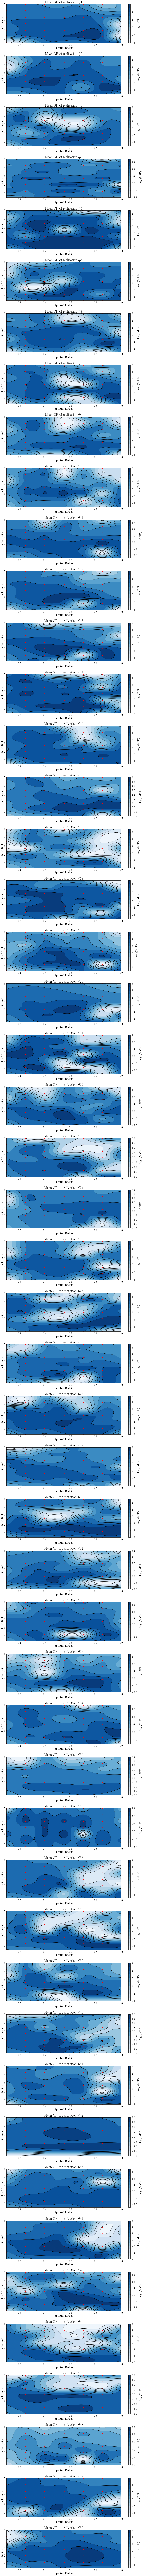

In [7]:
# Plot Gaussian Process reconstruction for each network in the ensemble afte n_tot evaluations
# The GP reconstruction is based on the n_tot function evaluations decided in the search

# points to evaluate the GP at
n_length    = 100
xx, yy      = np.meshgrid(np.linspace(spec_in, spec_end,n_length), np.linspace(in_scal_in, in_scal_end,n_length))
x_x         = np.column_stack((xx.flatten(),yy.flatten()))
x_gp        = res.space.transform(x_x.tolist())     ##gp prediction needs this normalized format 
y_pred      = np.zeros((ensemble,n_length,n_length))

plt.rcParams["figure.figsize"] = (15,5*ensemble)
plt.rcParams["font.size"] = 20


fig = plt.figure()

for i in range(ensemble):
    # retrieve the gp reconstruction
    gp         = gps[i]
    
    plt.subplot(ensemble, 1, 1+i)
    
    y_pred[i] = -gp.predict(x_gp).reshape(n_length,n_length) # Final GP reconstruction for each realization at the evaluation points
    
    plt.title('Mean GP of realization \#'+ str(i+1))
    
    #Plot GP Mean
    plt.xlabel('Spectral Radius')
    plt.ylabel('Input Scaling')
    CS      = plt.contourf(xx, yy, y_pred[i],levels=10,cmap='Blues')
    cbar = plt.colorbar()
    cbar.set_label('-$\log_{10}$(MSE)',labelpad=15)
    CSa     = plt.contour(xx, yy, y_pred[i],levels=10,colors='black',
                          linewidths=1, linestyles='solid')
    plt.yticks([1,2,3,4,5])
    plt.xticks([0.2,0.4,0.6,.8,1])
    
    #   Plot the n_tot search points
    plt.scatter(x_iters[i,:,0],x_iters[i,:,1], c='r', marker='^')
    
fig.tight_layout()
plt.show()

## Save Results

In [8]:
#Save the details and results of the search for post-process
opt_specs = [spec_in,spec_end,in_scal_in,in_scal_end]

# to save the Gaussian Process reconstruction of the MSE in hyperparameter space
if save_GP_reconstruction:
    fln = './data/SL_GP_ ' + str(n_tot) + '_' + val.__name__ +'.h5'
    hf = h5py.File(fln,'w')
    hf.create_dataset('xx',data=xx)
    hf.create_dataset('yy',data=yy)
    hf.create_dataset('y_pred'   ,data=y_pred)
    hf.close()
# save optimal hyperparameters and details of the search
else:
    if model_informed:
        fln = './data/Lor_short_' + val.__name__ + '_' + str(ensemble) + '_' + str(n_grid) + \
        '_MI.h5'
    else:
        fln = './data/Lor_short_' + val.__name__ + '_' + str(ensemble) + '_' + str(n_grid) + '.h5'

    hf = h5py.File(fln,'w')
    hf.create_dataset('Parameters',data=par)
    hf.create_dataset('x_iters'   ,data=x_iters)
    hf.create_dataset('f_iters'   ,data=f_iters)
    hf.create_dataset('minimum'   ,data=minimum)
    hf.create_dataset('opt_specs' ,data=opt_specs)
    hf.close()